In [87]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

In [88]:
import fastbook

# 1. Download the dataset

In [89]:
path= untar_data(URLs.PASCAL_2007)

In [90]:
(path/'train').ls()

(#5012) [Path('/home/thai_mai/.fastai/data/pascal_2007/train/004073.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/009620.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/007294.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/009290.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/005116.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/007322.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/003706.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/004948.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/003465.jpg'),Path('/home/thai_mai/.fastai/data/pascal_2007/train/009027.jpg')...]

In [91]:
df= pd.read_csv(path/'train.csv')

In [92]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


# 2. Constructing a DataBlock

In [93]:
# Create a DataBlock object
dblock= DataBlock()

# Step 2: Usin the dblock to create a datasets object
dsets= dblock.datasets(df)

In [94]:
# You now can access to the train and valid data
dsets.train[0]

(fname               004699.jpg
 labels      pottedplant person
 is_valid                  True
 Name: 2358, dtype: object,
 fname               004699.jpg
 labels      pottedplant person
 is_valid                  True
 Name: 2358, dtype: object)

* As we can see here, this simply returns a rows of the DataFrame twice. This is because by default, the data block assumes we have two things: input and target. To solve it, do:

In [95]:
# Create a dblock object
dblock= DataBlock(get_x= lambda r: r['fname'],
                  get_y= lambda r: r['labels'])

# Create a dsets from this dblock
dsets= dblock.datasets(df)

In [96]:
dsets.train[0]

('004962.jpg', 'car')

### 2.1. Another way

* As the independent variable will need to be voncerted into a complete path so we can open it as an image, and the dependent variable will need to be split on the space character, so we have:

In [97]:
def get_x(r):
    return (path/'train'/r['fname'])

def get_y(r):
    return r['labels'].split(' ') # using split() as we maybe have more than 2 classes in an image

In [98]:
# Create a DataBlock object
dblock= DataBlock(get_x= get_x, get_y= get_y)

# Convert dblock into dsets
dsets= dblock.datasets(df)

In [99]:
# Access the training data sample
dsets.train[9]

(Path('/home/thai_mai/.fastai/data/pascal_2007/train/008484.jpg'), ['car'])

### 2.2. Using set of transforms

* To actually open the image and do the conversion to tensors, we will need to use a set of transforms; block types will provide us with those.

* We can use the same block types that we have used previously, with one exception: 
    + The **ImageBlock** will work finde again.
    + The **CategoryBlock** is not going to work, because now each image can have more than 2 classes --> Using **MultiCategoryBlock**

In [100]:
# Step 1: Create a dablock object
dblock= DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                  get_x= get_x,
                  get_y= get_y)

# Step 2: Converting thid dblock into dsets
dsets= dblock.datasets(df)

In [101]:
# Step 3: Acces a sample in the training set
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### 2.3. Create a splitter()

In [102]:
def splitter(df):
    # Taking the index of all not valid samples and create a list of these indexes
    train= df.index[~df['is_valid']].tolist()
    valid= df.index[df['is_valid']].tolist()
    return train, valid

In [103]:
train_out, valid_out= splitter(df)

In [104]:
train_out[:4]

[3, 5, 9, 11]

In [105]:
# Create a dblock with splitter
dblock= DataBlock(blocks= [ImageBlock, MultiCategoryBlock],
                  splitter= splitter,
                  get_x= get_x,
                  get_y= get_y)

In [106]:
# Converting dblock into dsets
dsets= dblock.datasets(df)

In [107]:
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [108]:
dsets.valid[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### 2.4. Ensure all the item has the same size

* To do this, using **RandomResizedCrop**

In [109]:
# step 1: Create a DataBlock object
dblock= DataBlock(blocks= [ImageBlock, MultiCategoryBlock],
                  splitter= splitter,
                  get_x= get_x,
                  get_y= get_y,
                  item_tfms= RandomResizedCrop(128, min_scale= 0.35))

# Step 2: Converting into dataloaders
dls= dblock.dataloaders(df)

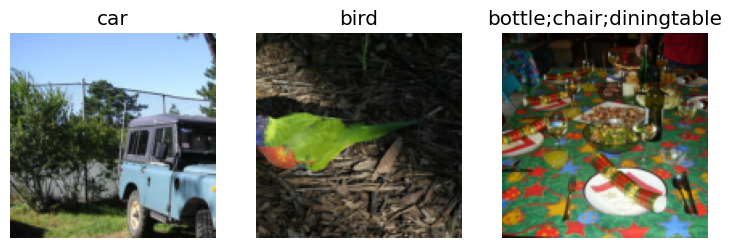

In [110]:
# Display a batch
dls.show_batch(nrows= 1, ncols= 3)

# 3. Binaray Cross Entropy

In [111]:
# Step 1: Create a Learner object

In [124]:
learn= cnn_learner(dls, resnet18)

/home/thai_mai/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thai_mai/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 3.1. How to get the activation function values
* What is this? This is the ouput of our model

In [125]:
# Example: Grabbing a mini-batch from our DataLoader
x, y = to_cpu(dls.train.one_batch())
# Step 2: passing this batch into the model
activs= learn.model(x)

In [126]:
activs.shape

torch.Size([64, 20])

* **activs** has this shape, because we have 64 samples in this batch and we have 20 categories to classify

In [127]:
# See the first sample
activs[0]

TensorImage([ 1.1643, -0.1119, -2.5008,  2.2802,  3.9768,  0.2953, -0.1283, -1.0181, -0.5413,  1.9169,  0.3728,  1.6839,  1.9866,  0.3929, -0.2996, -0.7901, -1.1831, -1.6673,  2.8663,  0.7518],
            grad_fn=<AliasBackward0>)

* Note: Getting Model Activations: Knowing how to manually get a mini-batch and pass it into a model, and look at the activations and loss, is really important for debugging your model. It is also very helpful for learning, so that you can see exactly what is going on.

In [128]:
y.shape

torch.Size([64, 20])

### 3.2. Using the correct loss function

* Because we habe one-hot-encoded dependent variable. we can't directly use **nll_loss** or **soft_max**---> we can not use **Cross Entroy**.

* **softmax** requires all predictions sum to 1, and tends to push one activation to be much larger than the otherse; however, we may well have multiple objects that we are confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea.

* **nll_loss** returns the value of just one activation: the single activation corresponding with the single label for an item. This does not make sense when we have multiple labels

* Sinve we have one-hot-encoded target, we will use BCEWithLogitsLoss

In [129]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TypeError: no implementation found for 'torch.nn.functional.binary_cross_entropy_with_logits' on types that implement __torch_function__: [<class 'fastai.torch_core.TensorImage'>, <class 'fastai.torch_core.TensorMultiCategory'>]

In [130]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [131]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/home/thai_mai/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/thai_mai/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:16<00:00, 6.22MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.951151,0.695381,0.237112,00:17
1,0.826237,0.556918,0.292430,00:17
2,0.604473,0.201330,0.823884,00:17
3,0.361829,0.125482,0.940159,00:17


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136965,0.119051,0.944721,00:18
1,0.119534,0.104681,0.950478,00:18
2,0.098900,0.101019,0.953486,00:18


# 10.Understanding Cross Entroy 

### 10.1. Cross entropy with pytorch

In [ ]:
# Step 1: Create a ground truth labels for 6 samples, where 1 is 3s and 0 is 7s
targets= tensor([0,1,0,1,1,0])

In [ ]:
# Step 2: Create an activation function (the output of the model)
acts= torch.randn((6,2))*2

In [ ]:
acts

In [ ]:
# Step 3: Applying the softmax function for model output
sm_acts= torch.softmax(acts, dim=1)
sm_acts

In [ ]:
# Step 4: Getting the probability to be 3
probab_be_3= sm_acts[:,0]
probab_be_3